# ***First of all, I will import the Packages I will use through the Notebook.***

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import shutil
from sklearn.metrics import confusion_matrix

# ***Loading and Preprocessing the Data***

In [2]:
# Mounting the Drive to get the Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# First, I will need to unzip the Dataset
!unzip '/content/drive/MyDrive/valifyTask/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [4]:
# This cell is responsible for preparing the test set
old_folder = '/content/asl_alphabet_test/asl_alphabet_test'
new_folder = './asl_alphabet_test1'

# Making New folder to paste the test data in
os.mkdir(new_folder)

# The Paths of both the training set and the Test Set
test_dir = new_folder
train_dir = '/content/asl_alphabet_train/asl_alphabet_train'


for file in os.listdir(old_folder):
  shutil.copy(os.path.join(old_folder, file), new_folder)

# Because the Test dataset contains only 28 images, this will cause problems when trying to calculate and plot the confusion matrix
# For this I am going to copy an image of the non existing class from the training set to the test set
shutil.copy(os.path.join(train_dir, 'del/del1.jpg'), new_folder)
os.rename(os.path.join(new_folder, 'del1.jpg'), os.path.join(new_folder, 'del_test.jpg'))

# ***Now, I will define the hyperparameters***

In [5]:
input_shape = (128, 128, 3)                                           # Shape of the resized input Image
split_ratio = 0.1                                                     # Ratio of splitting the data set into training and validation sets
m = 87000                                                             # Number of training examples
batch_size = 64                                                       # Size of the Batch of data we feed the learning Algorithm
num_classes = 29                                                      # Number of Classes in the data
target_size = (128, 128)                                              # Shape of the resized input Image
epochs = 20                                                            # Number of Epochs for the training process
steps_per_epoch = int(m * (1 - split_ratio) / batch_size)             # Number of steps for each epoch
validation_steps = int(m * split_ratio / batch_size)                  # Number of validation steps for each epoch
classes = os.listdir(train_dir)                                       # List of the classes
classes.sort()

In [6]:
# Now that I have prepared the test data and defined the hyperparameters, I will use the ImageDataGenerator API to load the data
# The ImageDataGenerator will be also used for Data Augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               samplewise_center=True, 
                               samplewise_std_normalization=True,
                               rotation_range = 10,
                               validation_split = split_ratio)

In [7]:
# Loading the DataSets
train_generator = train_gen.flow_from_directory(train_dir, target_size=target_size,
                                                shuffle=True, seed=13,
                                                class_mode='categorical',
                                                batch_size=batch_size, subset="training")

val_generator = train_gen.flow_from_directory(train_dir, target_size=target_size,
                                              shuffle=True, seed=13,
                                              class_mode='categorical',
                                              batch_size=batch_size, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


# ***Defining the Model***

In [8]:
# I will use transfer learning and I will use MobileNetV2 architecture as the backbone.
base_model = MobileNetV2(include_top=False, input_shape = input_shape)

# Now, I will Define my Classifier / Decoder
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(29, activation='softmax')(x)

# Integrate the whole Model
model = Model(base_model.input, x)

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
# Printing the Summary of the Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

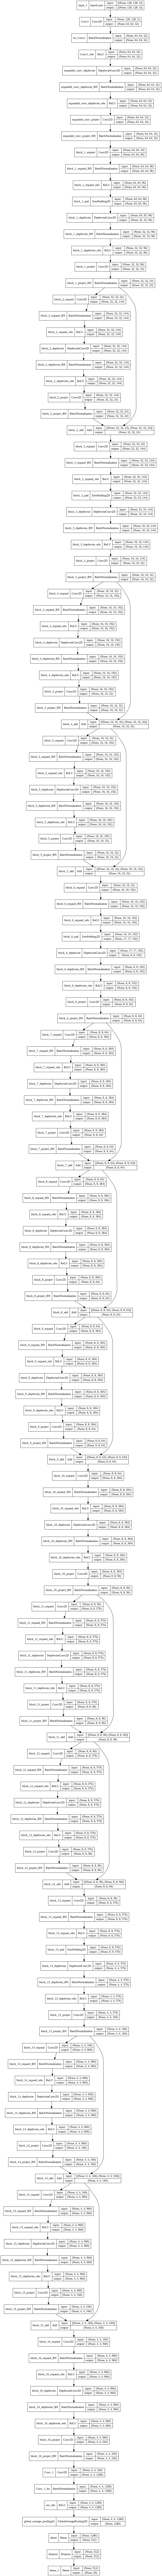

In [10]:
# Plotting the Model to visualize the tensorboard graph
plot_model(model, to_file='./drive/MyDrive/valifyTask/model.png', show_shapes=True)

# ***Compiling the Model***

In [11]:
# I will use the following callbacks

# To save the best Model
modelcheckpoint = ModelCheckpoint(monitor='val_loss',
                                  filepath='./best_model.hdf5',
                                  save_best_only=True)

# To avoid overfitting, Stop early when the validation loss saturates 
earlystopping = EarlyStopping(monitor='val_loss', patience=5)

# To reduce the Learning rate during training. This will reduce the probability of overshooting the minimum
reduce_LR = ReduceLROnPlateau(monitor='val_loss',
                              factor=1e-1,
                              patience=10,
                              verbose=1,
                              min_lr = 2e-6)

In [12]:
# Compiling the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ***Training the Model***

In [13]:
# Fitting the Model
history = model.fit_generator(train_generator, validation_data=val_generator,
                                        callbacks=[earlystopping, reduce_LR, modelcheckpoint],
                                        epochs=epochs, steps_per_epoch=steps_per_epoch,
                                        validation_steps=validation_steps, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
1223/1223 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9574

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1223/1223 [==============================] - 456s 360ms/step - loss: 0.1526 - accuracy: 0.9574 - val_loss: 3.6787 - val_accuracy: 0.5962 - lr: 0.0010
Epoch 2/20
1223/1223 [==============================] - 425s 348ms/step - loss: 0.0551 - accuracy: 0.9864 - val_loss: 4.0501 - val_accuracy: 0.5431 - lr: 0.0010
Epoch 3/20
1223/1223 [==============================] - 425s 347ms/step - loss: 0.0418 - accuracy: 0.9899 - val_loss: 1.7588 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 4/20
1223/1223 [==============================] - 423s 346ms/step - loss: 0.0328 - accuracy: 0.9924 - val_loss: 1.3349 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 5/20
1223/1223 [==============================] - 428s 350ms/step - loss: 0.0362 - accuracy: 0.9919 - val_loss: 1.0959 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 6/20
1223/1223 [==============================] - 423s 346ms/step - loss: 0.0241 - accuracy: 0.9945 - val_loss: 2.8291 - val_accuracy: 0.6426 - lr: 0.0010
Epoch 7/20
1223/1223 [=======================

# ***Plotting the Learning Curves***

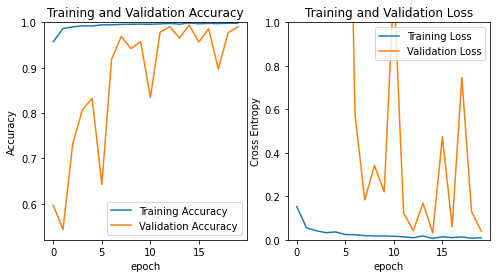

In [22]:
# Getting the Training and Validation Accuracies
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Getting the Training and Validation Losses
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the Learning Curves
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# ***Testing the Model***

Actual class: nothing 
 Predicted class: nothing


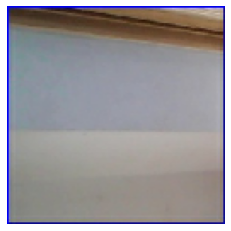

Actual class: space 
 Predicted class: space


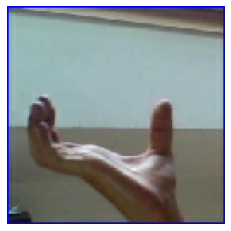

Actual class: S 
 Predicted class: S


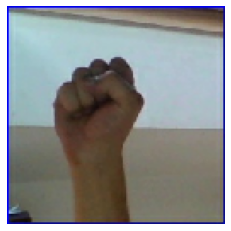

Actual class: N 
 Predicted class: N


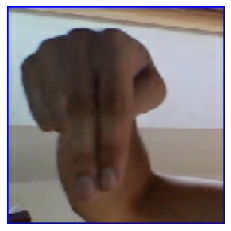

Actual class: X 
 Predicted class: X


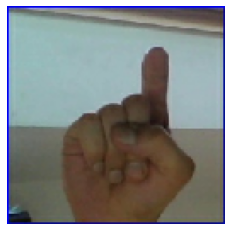

Actual class: M 
 Predicted class: M


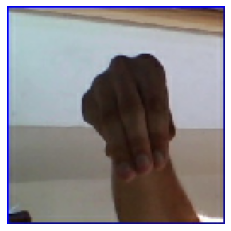

Actual class: L 
 Predicted class: L


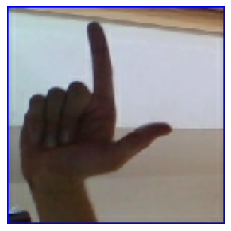

Actual class: C 
 Predicted class: C


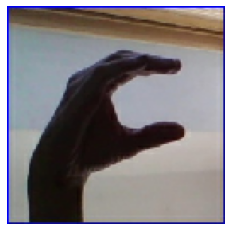

Actual class: F 
 Predicted class: F


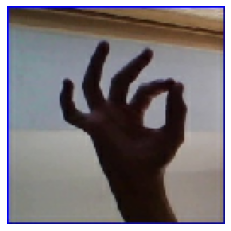

Actual class: T 
 Predicted class: T


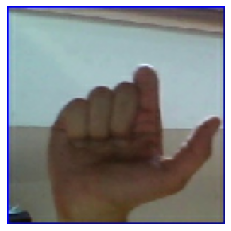

Actual class: O 
 Predicted class: O


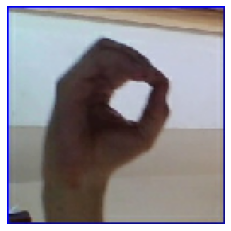

Actual class: P 
 Predicted class: P


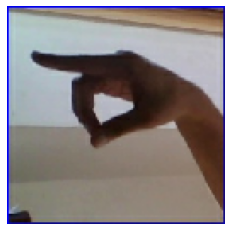

Actual class: I 
 Predicted class: I


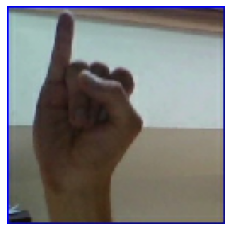

Actual class: W 
 Predicted class: W


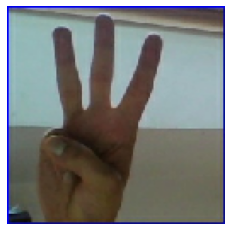

Actual class: E 
 Predicted class: E


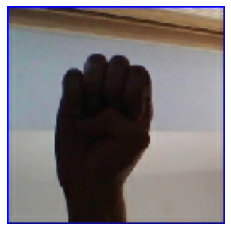

Actual class: A 
 Predicted class: A


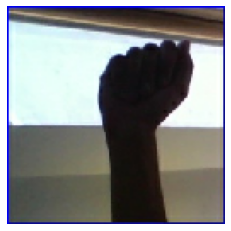

Actual class: Q 
 Predicted class: Q


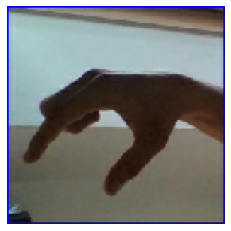

Actual class: K 
 Predicted class: K


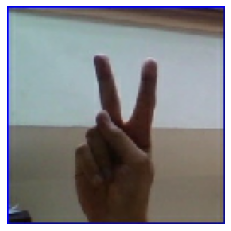

Actual class: del 
 Predicted class: del


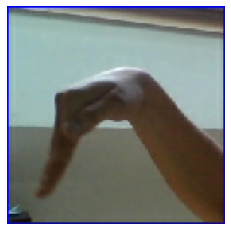

Actual class: U 
 Predicted class: U


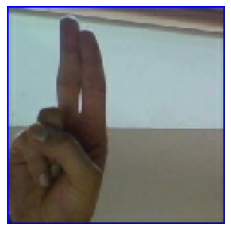

Actual class: R 
 Predicted class: R


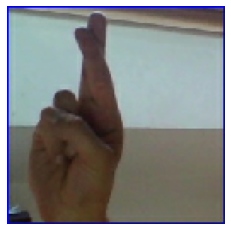

Actual class: Y 
 Predicted class: Y


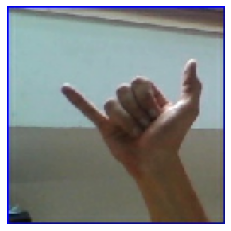

Actual class: Z 
 Predicted class: Z


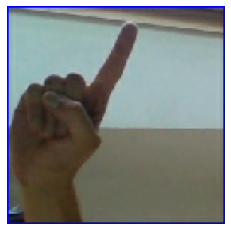

Actual class: V 
 Predicted class: V


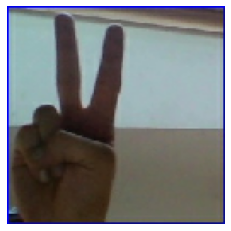

Actual class: H 
 Predicted class: H


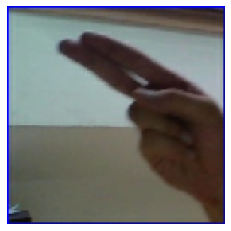

Actual class: J 
 Predicted class: J


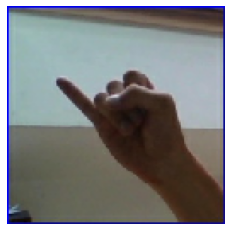

Actual class: G 
 Predicted class: G


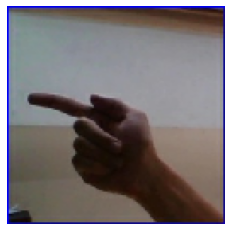

Actual class: B 
 Predicted class: B


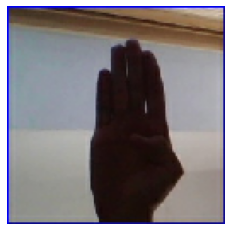

Actual class: D 
 Predicted class: D


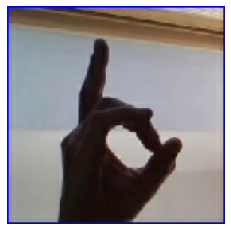

In [23]:
# I will test my model through three Different Methods:
#  1- I will loop through the test set and check the predictions of each individual Image
#  2- I will plot the Confusion Matrix
#  3- I will calculate the test Accuracy
# Here is the first proposed approach 
Y_actual = [file_name.split('_')[0] for file_name in os.listdir(new_folder)]
Y_predicted = []
for i, test_image in enumerate(os.listdir(new_folder)):
    image_location = new_folder + '/' + test_image
    img = tf.io.read_file(image_location)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, target_size, method='nearest')

    plt.figure()
    plt.axis('Off')
    plt.imshow(img)
    img = np.array(img) / 255.
    img = img.reshape((1, input_shape[0], input_shape[1], input_shape[2]))
    img = train_gen.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    Y_predicted.append(predicted)
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    plt.show()

# ***Printing and Plotting the Confusion Matrix***

In [24]:
# Calulating the Confusion Matrix
confusion_matrix1 = confusion_matrix(Y_actual, Y_predicted)
print(confusion_matrix1)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 

In [25]:
# Plotting the Confusion Matrix
# Citation >> 'https://www.kaggle.com/shivam2811/asl-alphabet-classification-99-68'
def plot_confusion_matrix(confusion_matrix):
    cm = confusion_matrix
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

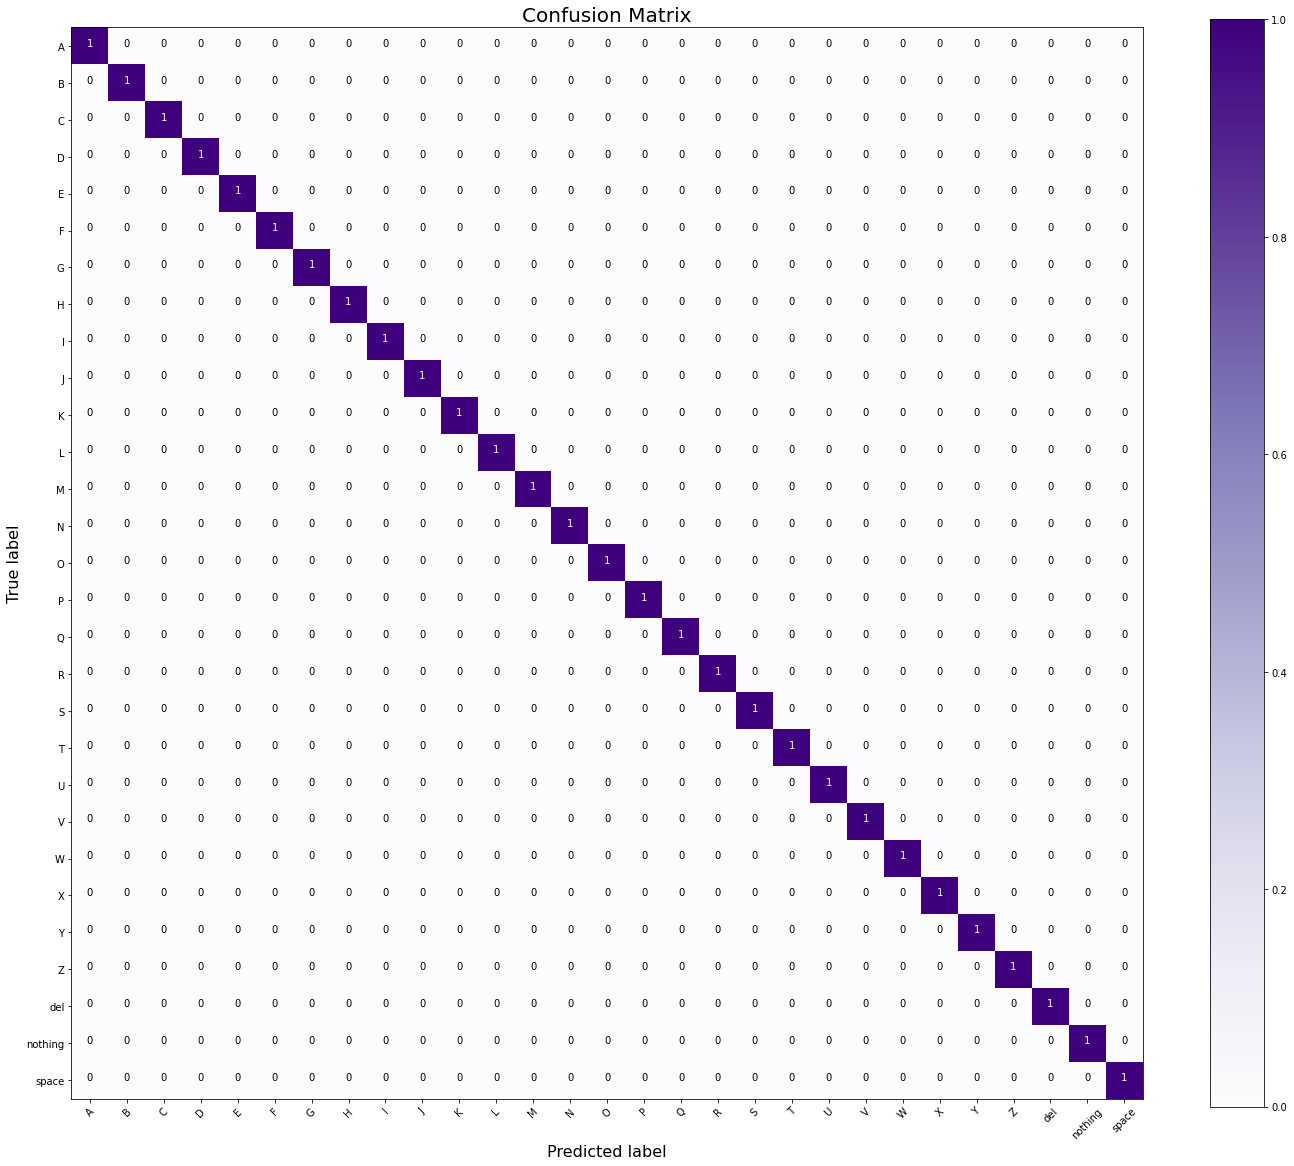

In [18]:
plot_confusion_matrix(confusion_matrix1)

In [26]:
# Calculating the Test Accuracy
Correct_answers = 0
for i in range(len(Y_actual)):
    if Y_actual[i] == Y_predicted[i]:
        Correct_answers += 1

print('The Testing Accuracy is {}'.format(Correct_answers / len(Y_actual)))

The Testing Accuracy is 1.0


# ***My Own Test Case***

In [35]:
model = load_model('./best_model.hdf5')

Predicted class: B


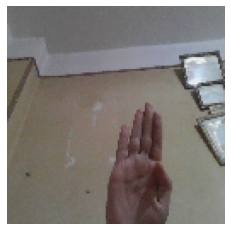

In [37]:
# This is an Image that I have captured using the camera of my own Laptop
img = tf.io.read_file('/content/2022-01-22-164957.jpg')
img = tf.image.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, target_size, method='nearest')

plt.figure()
plt.axis('Off')
plt.imshow(img)
img = np.array(img) / 255.
img = img.reshape((1, input_shape[0], input_shape[1], input_shape[2]))
img = train_gen.standardize(img)
prediction = np.array(model.predict(img))
predicted = classes[prediction.argmax()]
print('Predicted class: {}'.format(predicted))
plt.show()